# Lab:  Nonlinear Least Squares for Modeling Materials

In this lab, we will explore gradient descent on nonlinear least squares.  Suppose we wish to fit a model of the form,

     yhat = f(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  In nonlinear least squares, we find `w` by minimizing a least-squares function 

     J(w) = \sum_i (y_i - f(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  In general, this optimization has no closed-form expression.  So gradient descent is widely used.  

In this lab, we will implement gradient descent on nonlinear least squares in physical modeling of materials.  Specifically, e we will estimate parameters for expansion of copper as a function of temperature.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for trying nonlinear regression problem.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

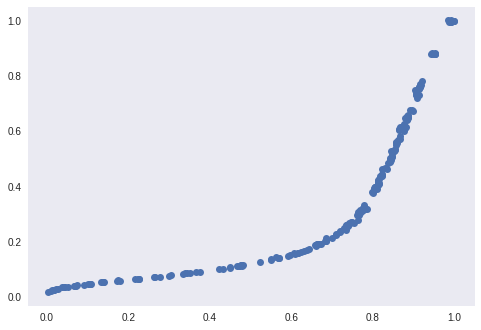

In [3]:
# TODO
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y,'o')
plt.grid()
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

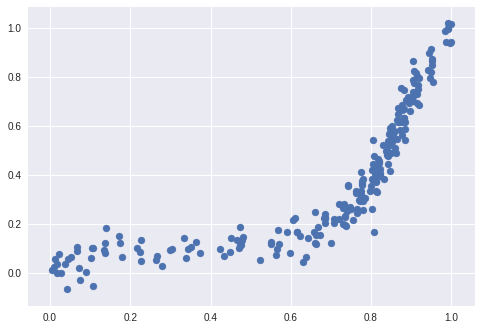

In [4]:
# TODO
yn = y + np.random.normal(loc=0.0, scale=0.05, size=y.shape[0])
plt.scatter(x,yn)
plt.show()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split( x, yn, test_size=0.33, shuffle=False)
print(yn.shape)

(236,)


## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [0]:
def predict(w,x):
    
  # Get the length
  d = (len(w)-1)//2
  # TODO. Extract a and b from w
  a = w[0:d+1]
  b = w[d+1:2*d+1]
  # TODO. Compute yhat. You may use the np.polyval function
  # But, remember you must flip the order the a and b
  yhat = (np.polyval(a[::-1],x))/(1+x*np.polyval(b[::-1],x))
  return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [8]:
d = 3

# # TODO. Create the transformed feature matrix

Z=np.zeros([x.shape[0],2*d])
for i in range(1,d+1):
  Z[:,i-1]=np.power(x,i)
for i in range(d+1,2*d+1):
  Z[:,i-1]=np.multiply(np.power(x,i-d),y)
  
# TODO. Fit with parameters with linear regression
regr = LinearRegression().fit(Z, y)
print(regr.score(Z, y))

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit

winit=np.zeros(7)
winit[0] = regr.intercept_
winit[1:4] =regr.coef_[0:3]
winit[4:7] =-regr.coef_[3:6]
print(winit)

0.9999858065659775
[ 0.02389422  0.1413507  -0.42007919  0.29811599 -2.24491986  1.49559312
 -0.20751461]


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

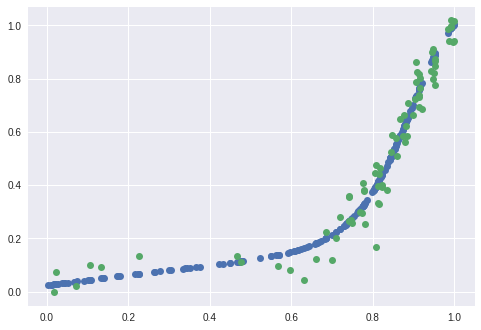

In [9]:
# TODO
xp = np.linspace(0,1,1000)
yhat = predict(winit,x[0:1000])
plt.plot(x[0:1000],yhat,'o')
plt.plot(xts,yts,'o')
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

0.9999767971948349
[ 0.1610664  -0.3764923   0.23680583  1.33150187  0.28766566 -0.66483423]
[ 0.02494345  0.1610664  -0.3764923   0.23680583]
[-1.33150187 -0.28766566  0.66483423]
[ 0.02494345  0.1610664  -0.3764923   0.23680583 -1.33150187 -0.28766566
  0.66483423]


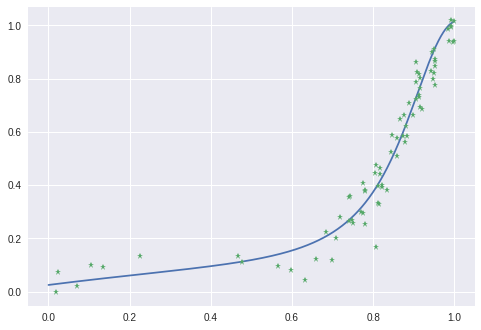

In [10]:
# TODO. Fit with parameters with linear regression
regr = Ridge(alpha=1e-3)
regr.fit(Z, y)
print(regr.score(Z, y))

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
print(regr.coef_)
a=np.append(regr.intercept_,regr.coef_[0:3])
b=-regr.coef_[3:6]
print(a)
print(b)
winit=np.append(a,b)
print(winit)

#TODO
#Plot the results as above.
xp = np.linspace(0,1,1000)
yhat = predict(winit,xp)
plt.plot(xp,yhat)
plt.plot(xts,yts,'*')
plt.show()

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [0]:
def feval(w,x,y): 
  # TODO.  Parse w
  d = (len(w)-1)//2
  a = w[0:4]
  b = w[4:7]

  # TODO.  Znum[i,j] = x[i]**j
  Znum=np.zeros((x.shape[0],4))
  for i in range(0,x.shape[0]):
    for j in range(0,4):
      Znum[i,j] = x[i]**j
  #Znum[i,:]=np.array([1,x[i],x[i]**2,x[i]**3])

  # TODO.  Zden[i,j] = x[i]**(j+1)
  Zden=np.zeros((x.shape[0],3))
  for i in range(0,x.shape[0]):
    for j in range(0,3):
      Zden[i,j] = x[i]**(j+1)

  # TODO.  Compute yhat 
  # Compute the numerator and denominator
  num=Znum.dot(a.T)
  den=Zden.dot(b.T)
  yhat=num/(1+den)
  yerr=y-yhat
  f = 0.5*np.sum((np.square(yerr)))

  # TODO.  Compute gradients
  dyhat_da0 = 1/(1+np.multiply(b[0],x)+np.multiply(b[1],x**2)+np.multiply(b[2],x**3))
  dyhat_da1 = x/(1+np.multiply(b[0],x)+np.multiply(b[1],x**2)+np.multiply(b[2],x**3))
  dyhat_da2 = (x**2)/(1+np.multiply(b[0],x)+np.multiply(b[1],x**2)+np.multiply(b[2],x**3))
  dyhat_da3 = (x**3)/(1+np.multiply(b[0],x)+np.multiply(b[1],x**2)+np.multiply(b[2],x**3))

  A=np.multiply(a[1],x)+np.multiply(a[2],x**2)+np.multiply(a[3],x**3)+a[0]
  B=1+x.dot(b[0])+(x**2).dot(b[1])+(x**3).dot(b[2])

  dyhat_db0 = -A*x*(B)**(-2)
  dyhat_db1 = -A*(x**2)*(B)**(-2)
  dyhat_db2 = -A*(x**3)*(B)**(-2)
  
  dJ_da0 = -np.sum((y-yhat)*dyhat_da0)
  dJ_da1 = -np.sum((y-yhat)*dyhat_da1)
  dJ_da2 = -np.sum((y-yhat)*dyhat_da2)
  dJ_da3 = -np.sum((y-yhat)*dyhat_da3)
  
  dJ_db0 = -np.sum((y-yhat)*dyhat_db0)
  dJ_db1 = -np.sum((y-yhat)*dyhat_db1)
  dJ_db2 = -np.sum((y-yhat)*dyhat_db2)
  
  fgrad = np.hstack([dJ_da0,dJ_da1,dJ_da2,dJ_da3, dJ_db0,dJ_db1,dJ_db2])

  return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [16]:
# TODO

w0=winit

# Take a random initial point
# Perturb the point
step = 1e-6
w1 = w0 + step*np.random.randn(7)

# Measure the function and gradient at w0 and w1
f0, fgrad0 = feval(w0,xtr,ytr)
f1, fgrad1 = feval(w1,xtr,ytr)

# Predict the amount the function should have changed based on the gradient
df_est = fgrad0.dot(w1-w0)

# Print the two values to see if they are close
print("Actual f1-f0 = %.10f" % (f1-f0))
print("Predicted f1-f0 = %.10f" % df_est)
print(f1)
print(f0)

Actual f1-f0 = -0.0000114037
Predicted f1-f0 = -0.0000114178
0.177652817474256
0.17766422116601605


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

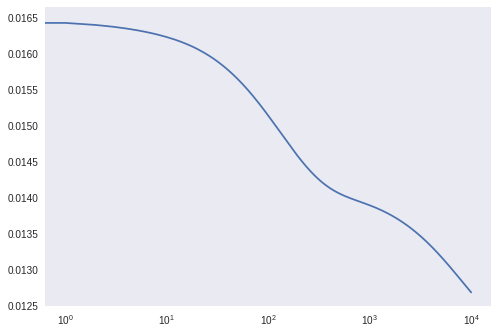

In [19]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step

f=np.zeros(nit)
fgrads=np.zeros((nit,7))
w0=winit
for it in range(nit):
  # Evaluate the function and gradient
  f0, fgrad0 = feval(w0,x,y)
  
  # Take a gradient step 
  w0 = w0 - step*fgrad0
  f[it]=f0
  fgrads[it,:]=fgrad0
  
  
t= np.arange(nit)
plt.semilogx(t, f)
plt.grid()
plt.show()


Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

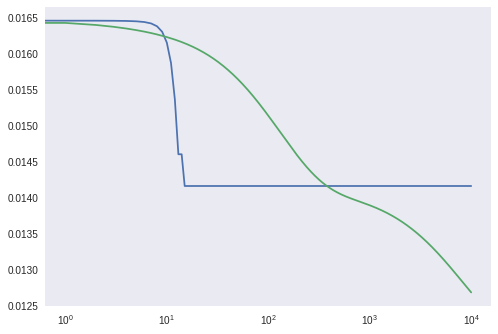

In [20]:
# TODO
nit = 10000
lr = 1e-6 # Initial step

f11t=np.zeros(nit)
fgrads=np.zeros((nit,7))
w0=winit
w00 = winit
f00, fgrad00 = feval(w0,x,y)

for it in range(nit):
  w11 = w00 - lr*fgrad0
  f11, fgrad11 = feval(w11,x,y)
  df_est = fgrad0.dot(w11-w00)
  alpha = 0.5
  if (f11-f00 < alpha*df_est) and (f11 < f00):
    lr = lr*2
    f00 = f11
    fgrad00 = fgrad11
    w00 = w11
  else:
    lr = lr/2
   
  f11t[it]=f00
  fgrads[it,:]=fgrad00
  
  
t = np.arange(nit)
plt.semilogx(t, f11t)
plt.semilogx(t, f)
plt.grid()
plt.show()

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

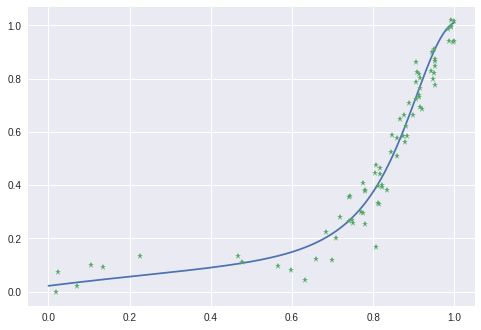

In [21]:
xp = np.linspace(0,1,1000)
yhat = predict(w00,xp)
plt.plot(xp,yhat)
plt.plot(xts,yts,'*')
plt.show()

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*d + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

In [0]:
# TODO
nit = 1000
step = 1e-5
beta = 0.99

In [0]:
# TODO
# plot yhat vs. x